In [113]:
import numpy as np
import pandas as pd
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import (confusion_matrix, classification_report, 
                           accuracy_score, precision_recall_fscore_support)
import warnings
warnings.filterwarnings('ignore')

In [114]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [115]:
class_names = ['left', 'right' ,'straight']

In [116]:
# Load Model
model_path = 'turn_classifier_use.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model architecture
model = models.convnext_tiny(pretrained=False)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

# Define the same transform used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
        ])

In [7]:
import os

# Specify the parent directory and the class subfolders in desired order
parent_dir = 'test_set'
class_folders = ['left', 'right', 'straight']

image_tensors = []
labels = []

for class_name in class_folders:
    class_dir = os.path.join(parent_dir, class_name)
    
    # Get sorted list of image files in the class directory
    image_files = sorted([
        fname for fname in os.listdir(class_dir)
        if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    
    for fname in image_files:
        path = os.path.join(class_dir, fname)
        img = Image.open(path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)  # Shape: [1, C, H, W]
        image_tensors.append(img_tensor)
        labels.append(class_name)

# Stack all image tensors into a single tensor [N, C, H, W]
X_test = torch.cat(image_tensors, dim=0).to(device)

# Convert labels to NumPy array
y_test = np.array(labels)


In [8]:
# Predictions
with torch.no_grad():
    output = model(X_test)
    y_pred_proba = F.softmax(output, dim=1)
    _, predicted_indices = output.max(1)

y_pred_classes = [class_names[i] for i in predicted_indices]

y_pred_proba_np = y_pred_proba.cpu().numpy()
y_pred_classes_np = np.array(y_pred_classes)

In [9]:
for i in range(len(y_pred_proba)):
    print(y_pred_proba_np[i], y_pred_classes_np[i])


[9.9817228e-01 1.6729755e-03 1.5471556e-04] left
[9.9832898e-01 1.5252590e-03 1.4581533e-04] left
[9.9736351e-01 2.3359193e-03 3.0051605e-04] left
[9.9810046e-01 1.6794536e-03 2.2010633e-04] left
[9.9806827e-01 1.7046575e-03 2.2716478e-04] left
[9.9856818e-01 1.1997035e-03 2.3208282e-04] left
[9.9840933e-01 1.3328472e-03 2.5776520e-04] left
[9.9867767e-01 1.0952732e-03 2.2699522e-04] left
[9.9833822e-01 1.4066331e-03 2.5517441e-04] left
[9.9873000e-01 1.0359315e-03 2.3404765e-04] left
[9.9873382e-01 1.0459684e-03 2.2020421e-04] left
[9.9850875e-01 1.2395814e-03 2.5162520e-04] left
[9.9847394e-01 1.3898833e-03 1.3618292e-04] left
[9.9830961e-01 1.4212851e-03 2.6904431e-04] left
[9.9887198e-01 8.9701585e-04 2.3106164e-04] left
[9.9825794e-01 1.4630074e-03 2.7907823e-04] left
[9.9833590e-01 1.4962910e-03 1.6783133e-04] left
[9.9846894e-01 1.3376398e-03 1.9342205e-04] left
[9.9850011e-01 1.3223453e-03 1.7754175e-04] left
[9.9840254e-01 1.4376123e-03 1.5984991e-04] left
[9.9844474e-01 1.408

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define hard test-time augmentations
hard_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.2), # Change brightness, contrast, saturation and hue --> simulate different lightning conditions
    transforms.RandomRotation(15), # random rotations --> simulate small robot rotations
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)), # affine translation --> simulate camera being off-centerd
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3), # change perspective --> simulate looking with a different angle
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Blurr --> simulate motion blurr 
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

# Use ImageFolder with hard transforms
test_dataset_hard = ImageFolder(root=parent_dir, transform=hard_transform)
test_loader_hard = DataLoader(test_dataset_hard, batch_size=32, shuffle=False)

# Get class name mapping
idx_to_class = {v: k for k, v in test_dataset_hard.class_to_idx.items()}

# Accumulate tensors and labels
image_tensors = []
labels = []

for inputs, targets in test_loader_hard:
    image_tensors.append(inputs)
    labels.extend([idx_to_class[i.item()] for i in targets])

# Concatenate into full tensor and label array
X_test_hard = torch.cat(image_tensors, dim=0).to(device)
y_test_hard = np.array(labels)

In [102]:
# Predictions
with torch.no_grad():
    output = model(X_test_hard)
    y_hard_pred_proba = F.softmax(output, dim=1)
    _, predicted_indices = output.max(1)

y_hard_pred_classes = [class_names[i] for i in predicted_indices.cpu().numpy()]
y_hard_pred_proba_np = y_hard_pred_proba.cpu().numpy()
y_hard_pred_classes_np = np.array(y_hard_pred_classes)
y_hard_pred_indices_np = predicted_indices.cpu().numpy()

In [103]:
for i in range(len(y_hard_pred_proba)):
    print(y_hard_pred_proba_np[i], y_hard_pred_classes_np[i])


[0.17487116 0.81388944 0.01123936] right
[9.9743026e-01 2.0836648e-03 4.8602591e-04] left
[0.7922109  0.18811044 0.01967857] left
[0.5129377  0.34599936 0.14106293] left
[0.6955787  0.22877899 0.07564233] left
[9.7992837e-01 1.9583931e-02 4.8774082e-04] left
[0.1995687  0.7125391  0.08789218] right
[0.07048907 0.33372307 0.5957879 ] straight
[9.8301411e-01 1.6189033e-02 7.9690036e-04] left
[0.20650013 0.7799334  0.01356645] right
[0.36153665 0.3468821  0.29158124] left
[0.99491453 0.00331851 0.00176699] left
[9.8676634e-01 1.2467098e-02 7.6657475e-04] left
[0.99226063 0.00599221 0.00174718] left
[9.9084342e-01 8.4617175e-03 6.9491169e-04] left
[0.29797786 0.69036883 0.01165326] right
[0.5092338  0.32541358 0.16535267] left
[0.9208522  0.06319802 0.01594978] left
[0.89205235 0.10622746 0.00172015] left
[9.899177e-01 9.558677e-03 5.236234e-04] left
[0.95231223 0.04445723 0.00323053] left
[9.9338949e-01 6.3928920e-03 2.1760822e-04] left
[0.9690242  0.0287501  0.00222566] left
[0.809409   

In [104]:
# Compute accuracy:
accuracy = accuracy_score(y_test_hard, y_hard_pred_classes_np)
print(accuracy)

0.9166666666666666


In [105]:
# Per-class metrics
class_names = ['left', 'right', 'straight']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Convert string labels to integers
y_test_hard_int = np.array([class_to_idx[label] for label in y_test_hard])
y_hard_pred_int = np.array([class_to_idx[label] for label in y_hard_pred_classes_np])

In [106]:
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_hard_int, y_hard_pred_int, average=None, labels=range(len(class_names))
)
print(precision, recall, f1, support)

[0.89473684 0.8852459  0.96774194] [0.85 0.9  1.  ] [0.87179487 0.89256198 0.98360656] [60 60 60]


In [107]:
# Macro averages
precision_macro = precision_recall_fscore_support(y_test_hard_int, y_hard_pred_int, average='macro')[0]
recall_macro = precision_recall_fscore_support(y_test_hard_int, y_hard_pred_int, average='macro')[1]
f1_macro = precision_recall_fscore_support(y_test_hard_int, y_hard_pred_int, average='macro')[2]

print(f"Macro-averaged Precision: {precision_macro:.3f}")
print(f"Macro-averaged Recall: {recall_macro:.3f}")
print(f"Macro-averaged F1-Score: {f1_macro:.3f}")

Macro-averaged Precision: 0.916
Macro-averaged Recall: 0.917
Macro-averaged F1-Score: 0.916


In [108]:
# Create detailed metrics table
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Add macro averages
metrics_df = pd.concat([
    metrics_df,
    pd.DataFrame({
        'Class': ['Macro Average'],
        'Precision': [precision_macro],
        'Recall': [recall_macro],
        'F1-Score': [f1_macro],
        'Support': [np.sum(support)]
    })
], ignore_index=True)


In [109]:
# Detailed metric per class
print("\nDetailed Metrics per Class:")
print(metrics_df.round(3))



Detailed Metrics per Class:
           Class  Precision  Recall  F1-Score  Support
0           left      0.895   0.850     0.872       60
1          right      0.885   0.900     0.893       60
2       straight      0.968   1.000     0.984       60
3  Macro Average      0.916   0.917     0.916      180


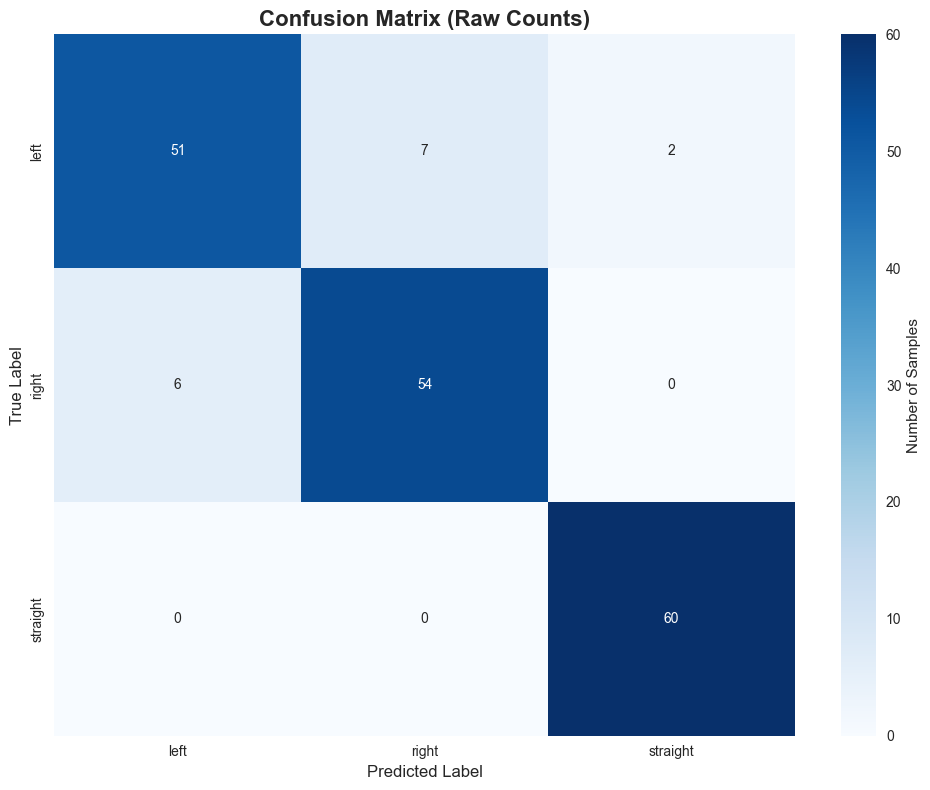

In [110]:
# Confusion matrix
cm = confusion_matrix(y_test_hard_int, y_hard_pred_int)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, 
           yticklabels=class_names,
           cbar_kws={'label': 'Number of Samples'})
plt.title('Confusion Matrix (Raw Counts)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


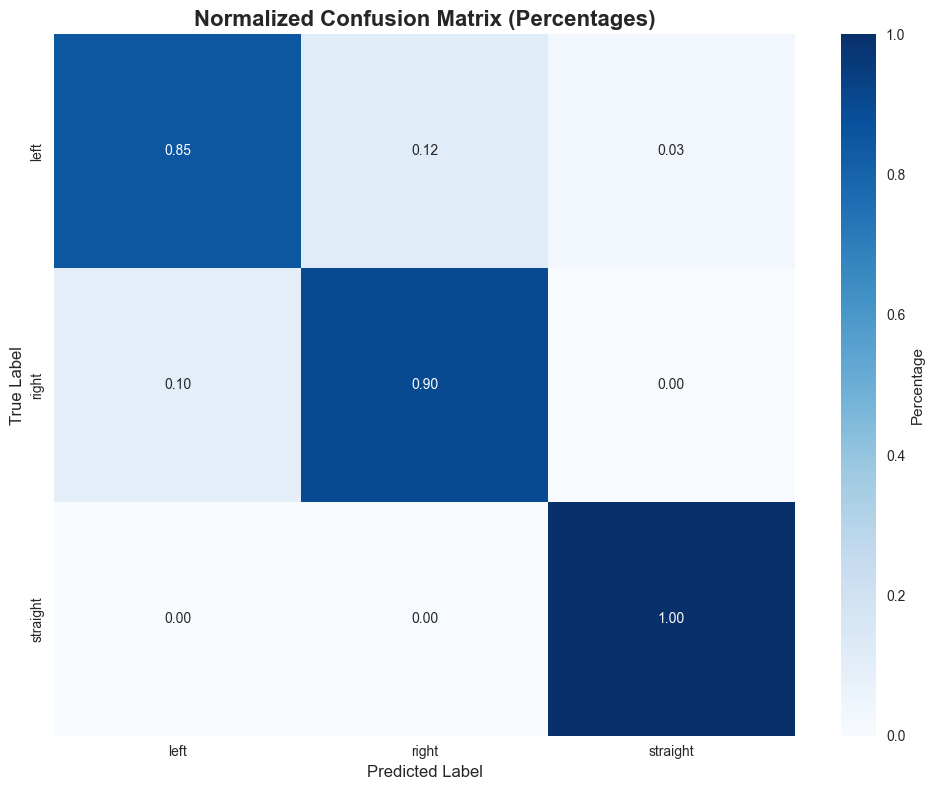

In [111]:
# Confusion matrix normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
           xticklabels=class_names, 
           yticklabels=class_names,
           cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (Percentages)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


Per-class Accuracy:
left: 0.850 (85.0%)
right: 0.900 (90.0%)
straight: 1.000 (100.0%)


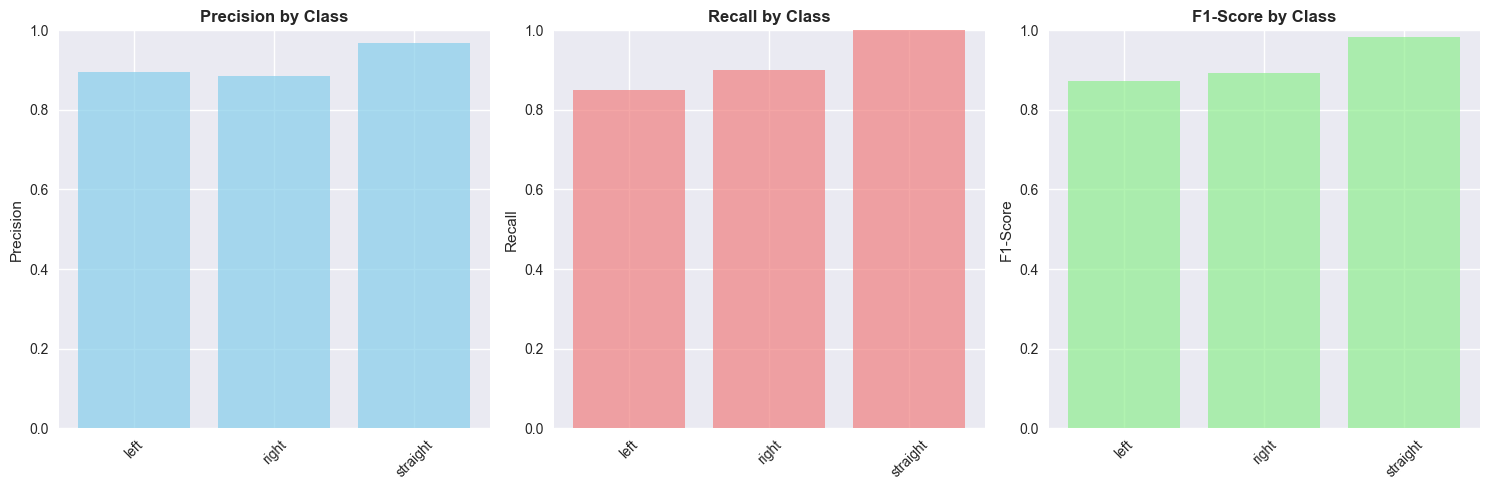

In [112]:
#%% Calculate per-class accuracy from confusion matrix

per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
print("\nPer-class Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {per_class_accuracy[i]:.3f} ({per_class_accuracy[i]*100:.1f}%)")

#%% Visualize metrics comparison

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision
axes[0].bar(class_names, precision, color='skyblue', alpha=0.7)
axes[0].set_title('Precision by Class', fontweight='bold')
axes[0].set_ylabel('Precision')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)

# Recall
axes[1].bar(class_names, recall, color='lightcoral', alpha=0.7)
axes[1].set_title('Recall by Class', fontweight='bold')
axes[1].set_ylabel('Recall')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)

# F1-Score
axes[2].bar(class_names, f1, color='lightgreen', alpha=0.7)
axes[2].set_title('F1-Score by Class', fontweight='bold')
axes[2].set_ylabel('F1-Score')
axes[2].set_ylim(0, 1)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()